In [1]:
from spyral_utils.plot import CutHandler, Histogrammer
from spyral_utils.nuclear import NuclearDataMap
from spyral_utils.nuclear.particle_id import serialize_particle_id, ParticleID
from spyral.core.constants import DEG2RAD
from spyral.core.run_stacks import form_run_string

import polars as pl
import matplotlib.pyplot as plt
from matplotlib.widgets import PolygonSelector
from pathlib import Path

%matplotlib widget

RAD2DEG = 1.0/DEG2RAD

import numpy as np

In [2]:
# Load config
# workspace_path = Path("C:\\Users\\schaeffe\\Desktop\\B11_sim\\B_11_12_56_MeV_106_MeV_beam")
workspace_path = Path("C:\\Users\\schaeffe\\Desktop\\e20009_B11_output")
estimation_result_path = workspace_path / "Estimation"

# Set the run range (inclusive)
run_min = 108
run_max = 320

# IC gate
ic_min_val = 900
ic_max_val = 1300

# Nucleus map
nuclear_map = NuclearDataMap()

In [3]:
# Set PID cut parameters for nucleus that will be gated on
pid_name = "proton" # name given to PID
pid_z = 1 # atomic number
pid_a = 1 # mass number
nucleus = nuclear_map.get_data(pid_z, pid_a)
pid_x_axis = "sqrt_dEdx" # This is the PID x-axis, matching a column name in the estimation dataframe
pid_y_axis = "brho" # This is the PID y-axis, matching a column name in the estimation dataframe
pid_path = Path("C:\\Users\\schaeffe\\Desktop\\B11_sim\\B_11_12_56_MeV_106_MeV_beam\\proton_sim.json") # Path to which we will write our PID


In [4]:
# Make utility objects for plotting and making cuts
grammer = Histogrammer()
handler = CutHandler()

In [5]:
# Create histograms
grammer.add_hist2d("particle_id", (400, 400), ((-10.0, 100), (-0.1, 2.5))) # Plot of dEdx vs. Brho (particle ID)
grammer.add_hist1d("ion_chamber", 4095, (-1.0, 4095.0)) # Plot of ion chamber (beam ID)
grammer.add_hist2d("kinematics", (720, 400), ((0.0, 180.0), (0.0, 3.0))) # Plot of polar angle vs. Brho (kinematics)

In [6]:
# Fill histograms
for run in range(run_min, run_max+1):
    run_path = estimation_result_path / f"{form_run_string(run)}.parquet"
    if not run_path.exists():
        continue
    df = pl.scan_parquet(run_path)

    # The below filter is optional. Filter the data on the ion chamber gate. Comment/Uncomment the line below to turn on/off the filter
    df = df.filter((pl.col('ic_amplitude') > ic_min_val) & (pl.col('ic_amplitude') < ic_max_val))
    df = df.collect()

    grammer.fill_hist2d('particle_id', df.select(pid_x_axis).to_numpy(), df.select(pid_y_axis).to_numpy()) # Use your custom axes
    grammer.fill_hist2d('kinematics', df.select('polar').to_numpy() * RAD2DEG, df.select('brho').to_numpy())
    grammer.fill_hist1d('ion_chamber', df.unique(subset=['event']).select('ic_amplitude').to_numpy())

In [7]:
print(run_path)

C:\Users\schaeffe\Desktop\e20009_B11_output\Estimation\run_0320.parquet


In [8]:
print(df.columns)
print(df)

['event', 'cluster_index', 'cluster_label', 'ic_amplitude', 'ic_centroid', 'ic_integral', 'ic_multiplicity', 'ic_sca_centroid', 'ic_sca_multiplicity', 'vertex_x', 'vertex_y', 'vertex_z', 'center_x', 'center_y', 'center_z', 'polar', 'azimuthal', 'brho', 'dEdx', 'sqrt_dEdx', 'dE', 'arclength', 'direction']
shape: (6_970, 23)
┌─────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ event   ┆ cluster_in ┆ cluster_l ┆ ic_amplit ┆ … ┆ sqrt_dEdx ┆ dE        ┆ arclength ┆ direction │
│ ---     ┆ dex        ┆ abel      ┆ ude       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ i64     ┆ ---        ┆ ---       ┆ ---       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ i64       │
│         ┆ i64        ┆ i64       ┆ f64       ┆   ┆           ┆           ┆           ┆           │
╞═════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 1506465 ┆ 1          ┆ 1         ┆ 947.0     ┆ … ┆ 32.770921 ┆ 2544

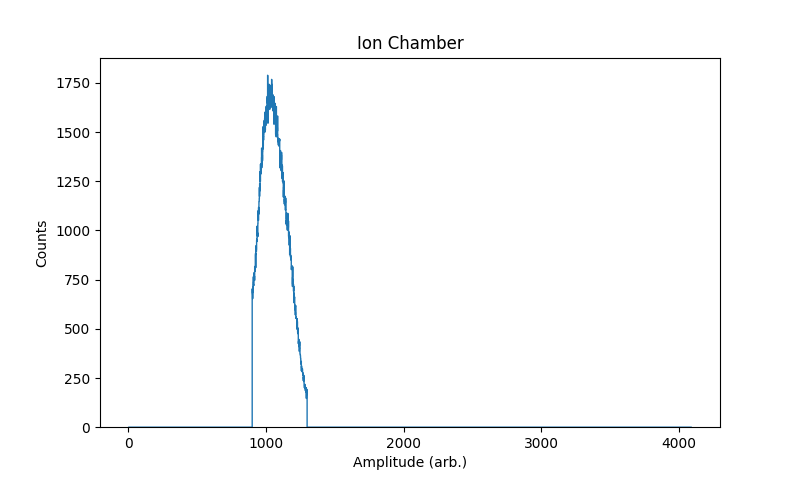

In [9]:
# Plot IC
ic = grammer.get_hist1d("ion_chamber")
fig, ax = plt.subplots(1,1)
ax.stairs(ic.counts, edges=ic.bins)
ax.set_title("Ion Chamber")
ax.set_xlabel("Amplitude (arb.)")
ax.set_ylabel("Counts")
fig.set_figwidth(8.0)

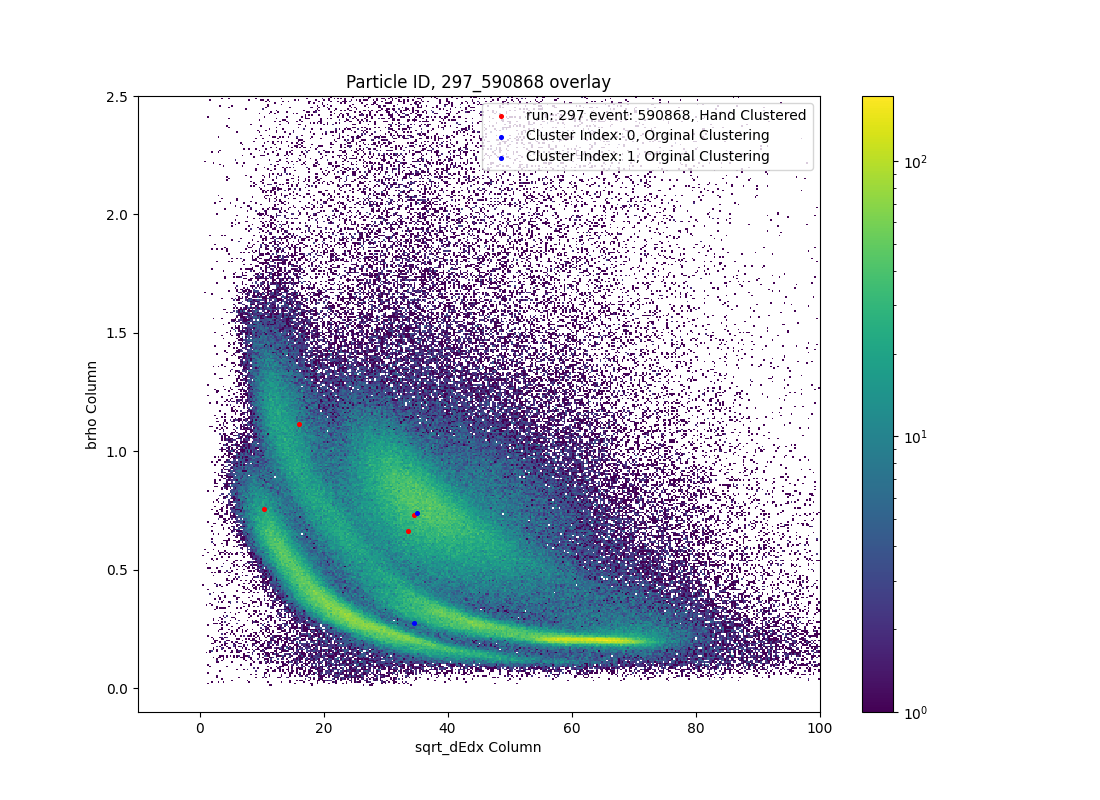

In [14]:
# Plot PID and draw gate by clicking points on plot
pid_hist = grammer.get_hist2d("particle_id")
fig, ax = plt.subplots(1,1)
# _ = PolygonSelector(ax, handler.mpl_on_select)
mesh = ax.pcolormesh(pid_hist.x_bins, pid_hist.y_bins, pid_hist.counts, norm='log')
# mesh = ax.pcolormesh(pid_hist.x_bins, pid_hist.y_bins, pid_hist.counts)

### Below Used to overlay individual events on top of PID ###

points = np.loadtxt("C:\\Users\\schaeffe\\Desktop\\e20009_analysis-dev_1_18_2025\\e20009_analysis-dev\\notebooks\\results_297_5908681_w_sqrt.txt", delimiter=",")  # Adjust filename if necessary
x_points = points[:, 0]  # First column
y_points = points[:, 1]  # Second column
plt.scatter(x_points, y_points, color='red', label='run: 297 event: 590868, Hand Clustered', s=7)
plt.scatter(34.587837296717154, 0.2776076390661179, color= "blue", label="Cluster Index: 0, Orginal Clustering", s = 7)
plt.scatter(35.069907149132206, 0.7397288313181537, color= "blue", label="Cluster Index: 1, Orginal Clustering", s = 7)
# plt.scatter(17.54516519, 1.364090956, color= "orange", label="Cluster Index: 1", s = 7)
# plt.scatter(19.74731355, 0.3730754262, color= "green", label="Cluster Index: 2", s = 7)
# plt.scatter(38.1383705, 0.9010846988, color= "red", label="Cluster Index: 3", s = 7)
plt.legend()

### END ###

fig.colorbar(mesh, ax=ax)
ax.set_title("Particle ID, 297_590868 overlay")
ax.set_xlabel(f"{pid_x_axis} Column")
ax.set_ylabel(f"{pid_y_axis} Column")
fig.set_figheight(8.0)
fig.set_figwidth(11.0)


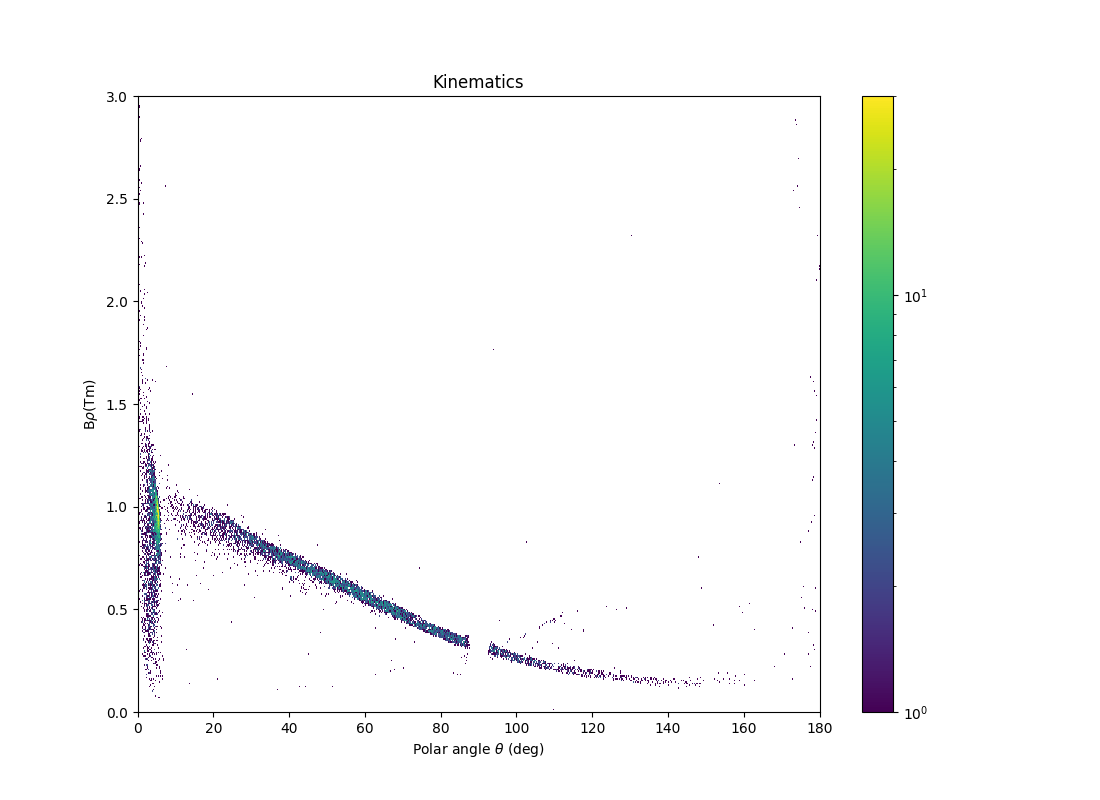

In [13]:
# Plot estimated kinematics
kine = grammer.get_hist2d("kinematics")
fig, ax = plt.subplots(1,1)
mesh = ax.pcolormesh(kine.x_bins, kine.y_bins, kine.counts, norm='log')
fig.colorbar(mesh, ax=ax)
ax.set_title("Kinematics")
ax.set_xlabel("Polar angle $\\theta$ (deg)")
ax.set_ylabel("B$\\rho$(Tm)")
fig.set_figheight(8.0)
fig.set_figwidth(11.0)

In [14]:
# Save PID
# If you've made multiple cuts, you'll want to change the name used here. Cuts are automatically named in the order they were made (first cut is cut_0, second cut_1, etc.)
cut = handler.cuts["cut_0"]
cut.name = pid_name
cut.x_axis = pid_x_axis # specify our axes
cut.y_axis = pid_y_axis
pid = ParticleID(cut, nucleus)
# Save our pid
serialize_particle_id(pid_path, pid)


In [15]:
print(cut)

In [16]:
# Make and fill kinematics and PID histograms gated on user input gate
grammer.add_hist2d("particle_id_gated", (400, 400), ((-10.0, 100.0), (-0.1, 2.5))) # Plot of dEdx vs. Brho (particle ID), gated on PID
grammer.add_hist2d("kinematics_gated", (720, 400), ((0.0, 180.0), (0.0, 3.0))) # Plot of polar angle vs. Brho (kinematics), gated on PID

for run in range(run_min, run_max+1):
    run_path = estimation_result_path / f"{form_run_string(run)}.parquet"
    if not run_path.exists():
        continue
    df = pl.scan_parquet(run_path)

    df = df.filter(pl.struct([pid_x_axis, pid_y_axis]).map_batches(pid.cut.is_cols_inside)) # apply PID
    # The below filter is optional. Filter the data on the ion chamber gate. Comment/Uncomment the line below to turn on/off the filter
    # df = df.filter((pl.col('ic_amplitude') > ic_min_val) & (pl.col('ic_amplitude') < ic_max_val))
    df = df.collect()

    grammer.fill_hist2d('particle_id_gated', df.select(pid_x_axis).to_numpy(), df.select(pid_y_axis).to_numpy())
    grammer.fill_hist2d('kinematics_gated', df.select('polar').to_numpy() * RAD2DEG, df.select('brho').to_numpy())

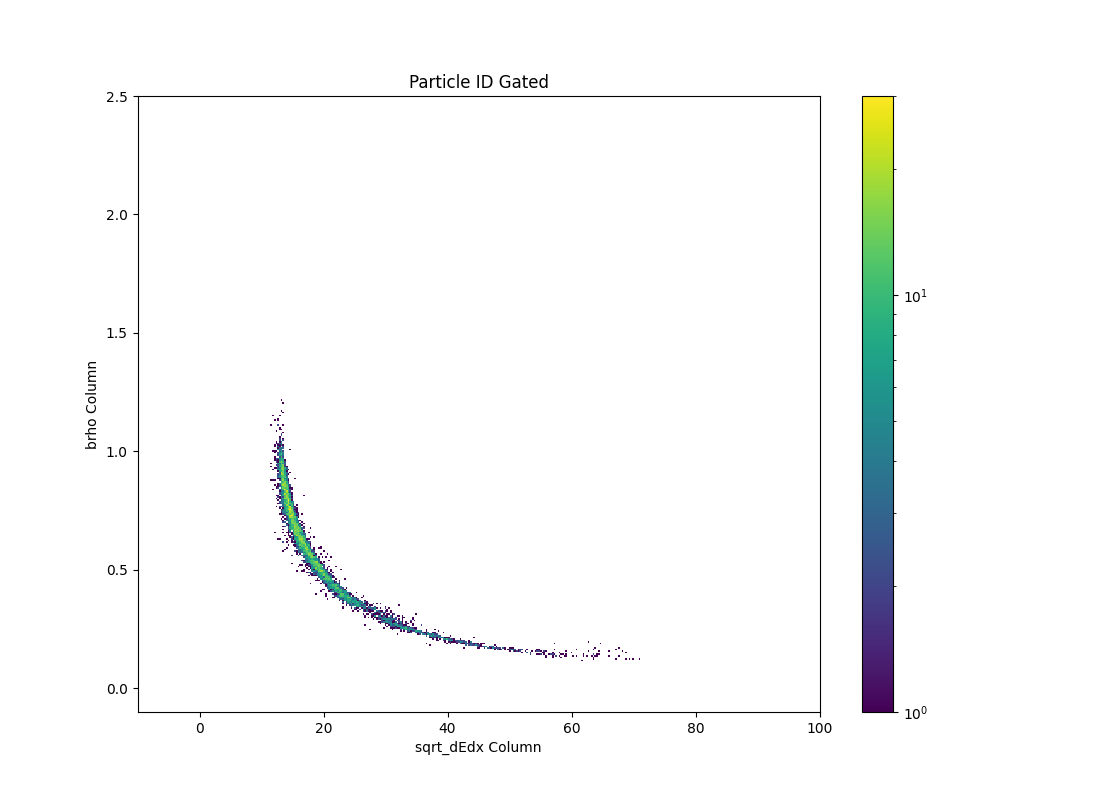

In [17]:
# Plot gated PID
pid_gated = grammer.get_hist2d("particle_id_gated")
fig, ax = plt.subplots(1,1)
mesh = ax.pcolormesh(pid_gated.x_bins, pid_gated.y_bins, pid_gated.counts , norm='log')
fig.colorbar(mesh, ax=ax)
ax.set_title("Particle ID Gated")
ax.set_xlabel(f"{pid_x_axis} Column")
ax.set_ylabel(f"{pid_y_axis} Column")
fig.set_figheight(8.0)
fig.set_figwidth(11.0)

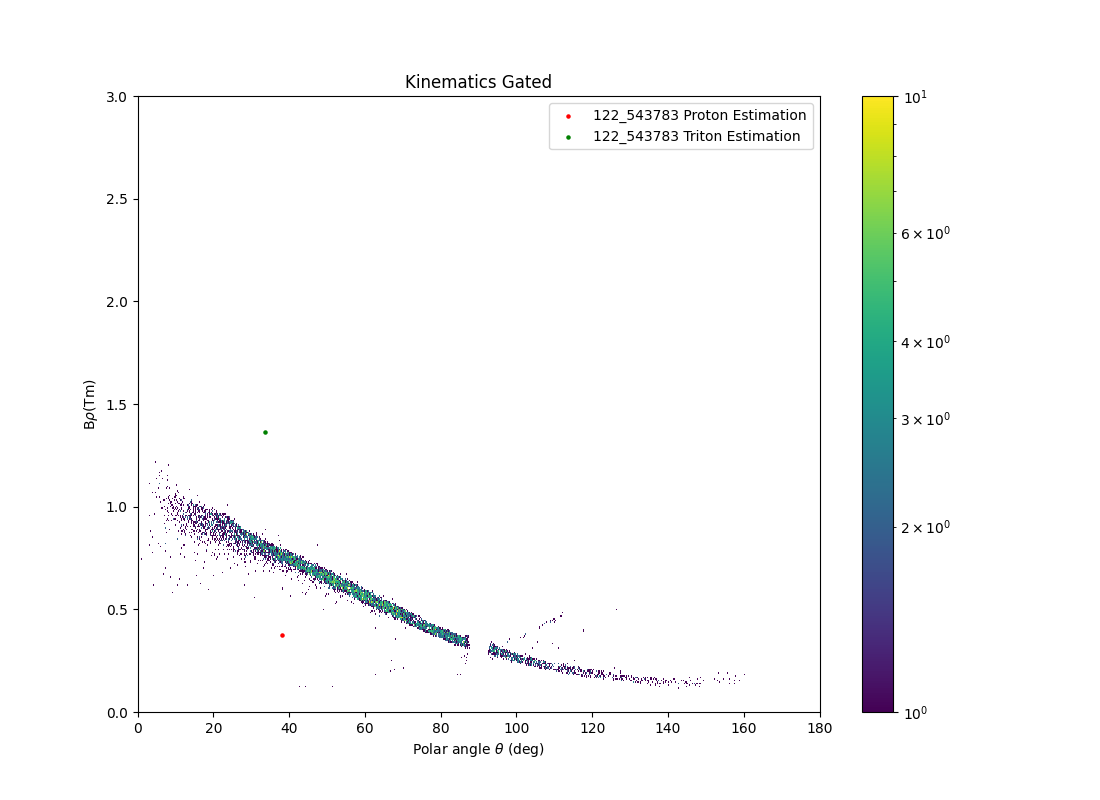

In [ ]:
# Plot gated kinematics
kine_gated = grammer.get_hist2d("kinematics_gated")
fig, ax = plt.subplots(1,1)
mesh = ax.pcolormesh(kine_gated.x_bins, kine_gated.y_bins, kine_gated.counts, norm='log')

plt.scatter(38.24460859, 0.3730754262, color='red', label='122_543783 Proton Estimation', s=5)
# plt.scatter(33.65452298, 1.364090956, color='green', label='122_543783 Triton Estimation', s=5)
plt.legend()

fig.colorbar(mesh, ax=ax)
ax.set_title("Kinematics Gated")
ax.set_xlabel("Polar angle $\\theta$ (deg)")
ax.set_ylabel("B$\\rho$(Tm)")
fig.set_figheight(8.0)
fig.set_figwidth(11.0)